In [119]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import ttest_ind

import constants

In [120]:
HIST_KWARGS_VEL = {
    'range': (0, 2.5),
    'bins': 25
}

FIGDIR = 'figs/'

def analyse_export(filename: str, figure_name_prefix: str):
    """
    Analyse a FIESTA kymograph export and generate histograms for the velocity
    and run length distributions.

    :param filename:
        Path to the exported text file
    :param figure_name_prefix:
        Prefix under which the generated histograms are saved.
    """
    print(f'Analysing file {filename}:')
    # Load the file
    dist_arr, time_arr, vel_arr = np.loadtxt(
        fname=filename,
        skiprows=1,
        usecols=(1,2,3),
        unpack=True
    )

    # Calculate mean and std
    mean = np.mean(vel_arr)
    std = np.std(vel_arr)
    print(f'Velocity  : mean {mean}, std {std}, std_err {std/np.sqrt(vel_arr.shape[0])}, median {np.median(vel_arr)}')

    # Generate velocity histogram
    fig, ax, hist, bin_edges = generate_histogramm(vel_arr, **HIST_KWARGS_VEL)
    ax.set_xlabel('Velocity $[\\dfrac{\mu m}{s}]$')
    ax.set_ylabel('Probability density [-]')
    ax.set_title(f'Dataset: {figure_name_prefix}, N = {np.shape(vel_arr)[0]}')
    ax.grid()

    # Fit a normal distribution onto the the histogram
    bin_centers = [np.mean(b_vals) for b_vals in zip(bin_edges[:-1], bin_edges[1:])]
    (fitted_mean, fitted_std), _ = curve_fit(
        f=lambda x, mean, std: norm.pdf(x, loc=mean, scale=std),
        xdata=bin_centers, ydata=hist,
        p0=(mean, std)
    )
    print(f'Fit params: mean {fitted_mean}, std {fitted_std}')

    # Draw the fit in the histogram
    vel_arr_plot = np.linspace(*HIST_KWARGS_VEL['range'], num=150)
    ax.plot(
        vel_arr_plot, norm.pdf(vel_arr_plot, loc=fitted_mean, scale=fitted_std),
        'k-', label='Fitted normal distribution'
    )

    # Add legend
    ax.legend()

    # Save the velocity histogram
    fig.savefig(f'{FIGDIR}/{figure_name_prefix}-velocity.pdf', bbox_inches='tight')
    print()

def generate_histogramm(arr, **kwargs):
    # Compute histogram
    hist, bin_edges = np.histogram(arr, density=True, **kwargs)
    bin_width = bin_edges[1] - bin_edges[0]

    # Plot histogram
    fig, ax = plt.subplots(figsize= constants.FIGSIZE)
    ax.bar(bin_edges[:-1], hist, width=bin_width, align='edge', label='Histogram')

    return fig, ax, hist, bin_edges

In [121]:
# Error estimation

# Load data
dist_arr, vel_arr = np.loadtxt(
    fname='kymograph_export/error_estimation/24C_ChannelB_63x_Opt1p6_10mW488Laser_100ms_GFP-Kin - Data.txt',
    skiprows=1,
    usecols=(1,3),
    unpack=True
)

dist_err = np.std(dist_arr)
vel_err = np.std(vel_arr)

print(f'Run length [mu m]: mean {np.mean(dist_arr)}, error {dist_err}')
print(f'Velocity [mu m / s]: mean {np.mean(vel_arr)}, error {vel_err}')

Run length [mu m]: mean 2.54942296, error 0.17037722840226746
Velocity [mu m / s]: mean 0.5694704, error 0.04272637686020195


Analysing file kymograph_export/24C-B/24C_ChannelB_63x_Opt1p6_10mW488Laser_100ms_GFP-Kin - Data.txt:
Velocity  : mean 0.7822445899999999, std 0.23887046495971806, std_err 0.016890692559820022, median 0.7698805
Fit params: mean 0.7673701602348195, std 0.17648049526735668

Analysing file kymograph_export/34C-B/34C_ChannelB_63x_Opt1p6_40mW488Laser_100ms_GFP-Kin - Data.txt:
Velocity  : mean 1.2957212723404257, std 0.2635410303649741, std_err 0.017191521250850227, median 1.253481
Fit params: mean 1.2464825673852464, std 0.18051996168548623



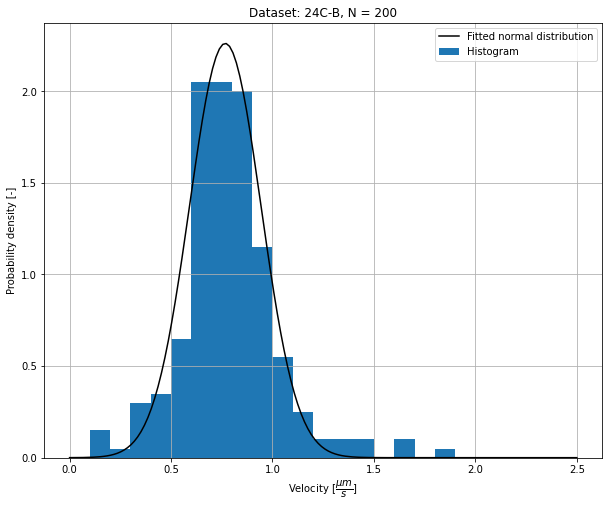

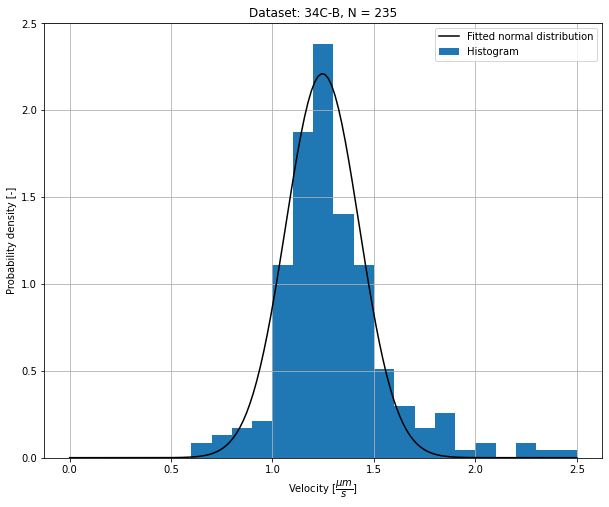

In [122]:
# Velocity and run length evaluation

# List of tuple(filename, output prefix)
EXPORT_FILE_NAMES = [
    ('kymograph_export/24C-B/24C_ChannelB_63x_Opt1p6_10mW488Laser_100ms_GFP-Kin - Data.txt', '24C-B'),
    ('kymograph_export/34C-B/34C_ChannelB_63x_Opt1p6_40mW488Laser_100ms_GFP-Kin - Data.txt', '34C-B')
]

for fname, label in EXPORT_FILE_NAMES:
    analyse_export(fname, label)

In [123]:
# Student's T-Test on the velocity distributions

# Load velocity data
v_arrs = [
    np.loadtxt(
        fname=filename,
        skiprows=1,
        usecols=(3),
        unpack=True
    )
    for filename, _ in EXPORT_FILE_NAMES
]

t_val, p_val = ttest_ind(v_arrs[0], v_arrs[1], equal_var=False)

print(f't-value: {t_val}, p-value: {p_val}')

t-value: -21.256178989664814, p-value: 4.0902631585039144e-69
